In [1]:
import cProfile
import jax
import lsdb
import os
import pandas as pd
import photod.locus as lt
import photod.bayes as bt

pd.set_option('display.max_columns', None)
jax.config.update('jax_platform_name', 'cpu')

Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

CPU times: user 1.12 s, sys: 460 ms, total: 1.58 s
Wall time: 205 ms


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - S82_fixed'}>)

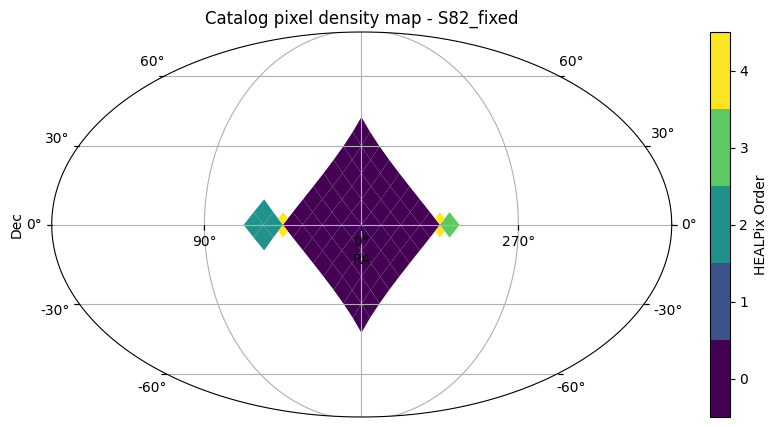

In [3]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed/")
s82.plot_pixels()

Next, read the stellar locus parametrization.

In [4]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False, datafile="/home/scampos/photoD/data/MSandRGBcolors_v1.3.txt") # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [5]:
kMr = 10 # 10x less samples
kFeH = 2 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [6]:
fitColors = ('ug', 'gr', 'ri', 'iz')
pix_order = 5
pix_index = 0
priorsRootName = f'/mnt/beegfs/scratch/scampos/photod/priors/TRILEGAL/S82/{pix_order}/{pix_index}'

Make 3D locus list with three ArGrid limits and resolutions.

In [7]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

In [8]:
from photod.parameters import GlobalParams

globalParams = GlobalParams(
    fitColors=fitColors,
    locusData=locusData,
    ArGridList=ArGridList,
    locus3DList=locus3DList,
    priorsRootName=priorsRootName,
)

In [9]:
df = s82.pixel_search([(pix_order,pix_index)]).compute().reset_index(drop=True)

Select a range of stars to process.

In [10]:
iStart = 0
iEnd = len(df)

In [ ]:
with cProfile.Profile() as profiler:
    # Set `returnAllInfo` to True to enable plotting later
    estimatesDf, results = bt.makeBayesEstimates3d(df, globalParams, iStart, iEnd, returnAllInfo=True)
    profiler.dump_stats("/home/scampos/photoD/bayes-3d.pstat")

In [12]:
estimatesDf

,glon,glat,FeHEst,FeHUnc,MrEst,MrUnc,chi2min,MrdS,FeHdS,ArEst,ArUnc,ArdS
0,174.537601,-49.030895,-0.860239,0.113677,5.736380,0.176540,10.384319,-38.261864,-18.312843,0.376534,0.039466,-233.235367
1,174.579778,-49.000538,-1.281481,0.105560,4.141246,0.431746,6.227755,-28.026934,-21.002289,0.310587,0.083400,-168.751434
2,174.600676,-49.009624,-1.955273,0.388790,9.953964,0.211185,17.033642,-43.774437,-8.411377,0.192730,0.019451,-248.542191
3,174.686073,-49.011621,-0.901030,0.307760,3.530498,1.544079,1.842926,-22.108982,-8.685225,0.244189,0.175011,-140.873367
4,174.653707,-48.969732,-0.590015,0.120649,5.726558,0.184213,17.846209,-39.685406,-17.454363,0.211826,0.038605,-232.615784
...,...,...,...,...,...,...,...,...,...,...,...,...
3976,176.945849,-47.336167,-0.631062,0.072811,5.017139,0.178996,18.432688,-36.414177,-17.014416,0.106055,0.041454,-221.368622
3977,177.085939,-47.282103,-0.162144,0.088992,5.701555,0.140310,112.968552,-45.131424,-18.469028,0.120125,0.029277,-268.673126
3978,176.930182,-47.116265,-0.296177,0.164842,4.566435,2.144234,38.693794,-40.603130,-14.501012,0.373175,0.155684,-253.188324
3979,177.134561,-46.988405,-0.774174,0.074388,4.593674,0.202915,8.442446,-35.645935,-17.494648,0.341450,0.040786,-212.412384


In [13]:
# Create directories for the plots and results
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [14]:
# Save estimates to disk
estimatesDf.to_csv('results/S82_Bayes_estimates.txt', index=False)

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0...
pts: 25 155


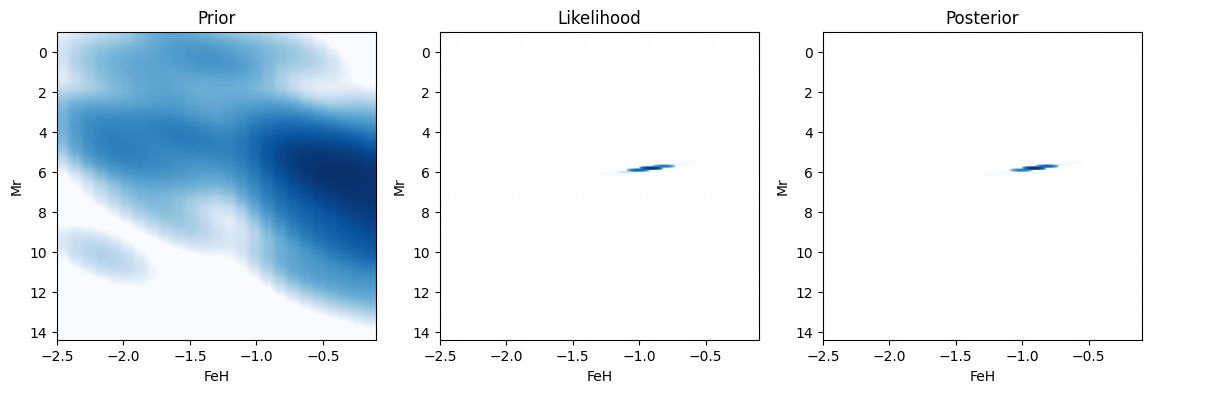

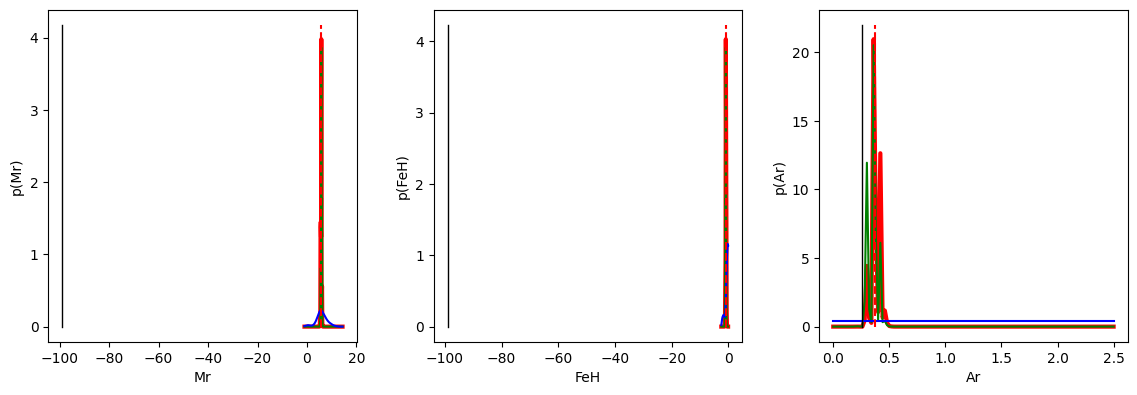

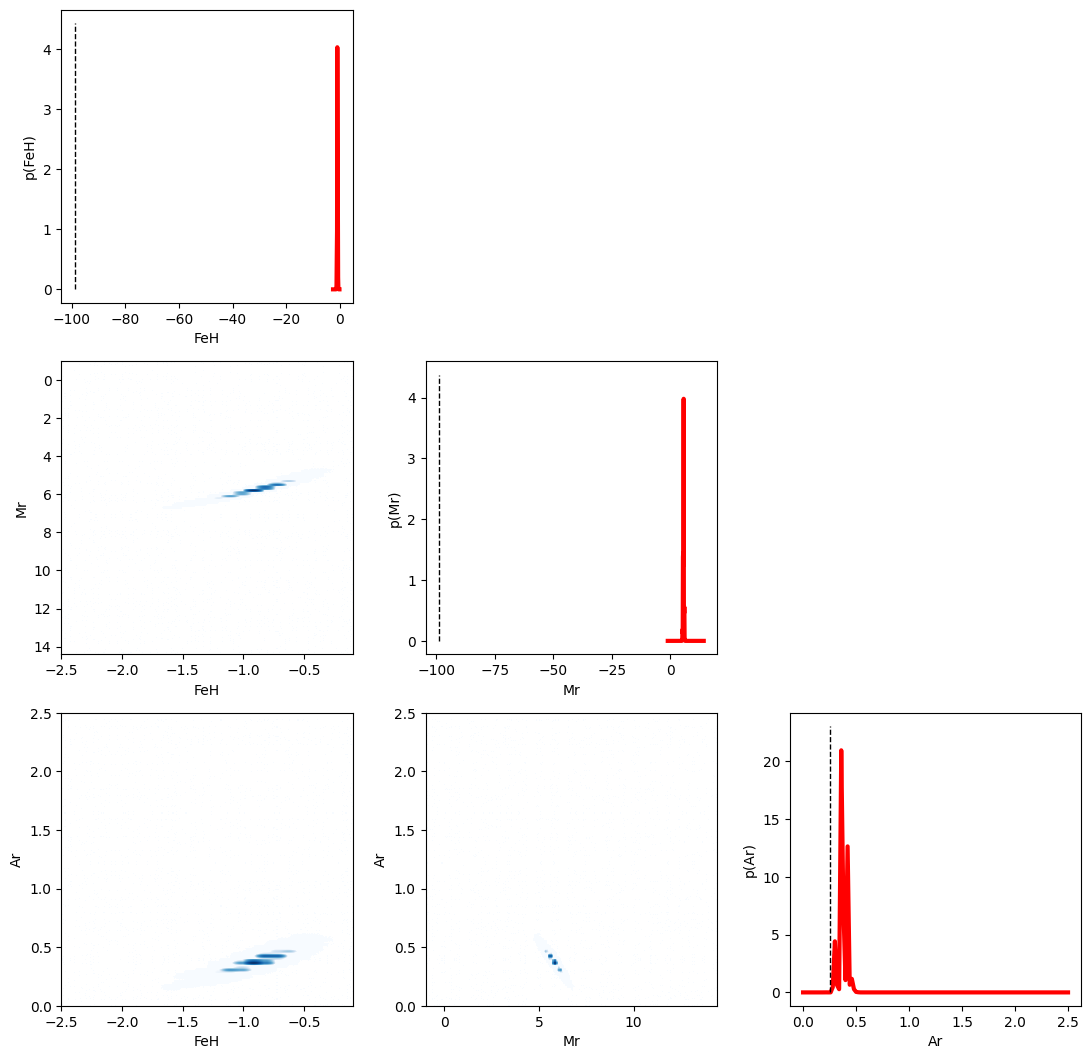

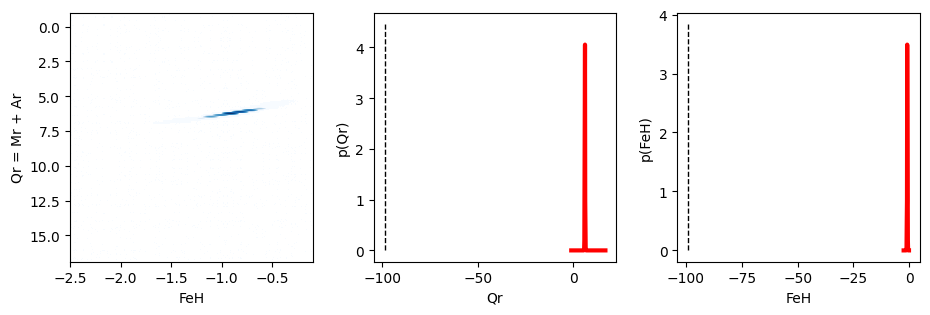

6.161519 0.13223252
Plotting star 100...
pts: 25 155


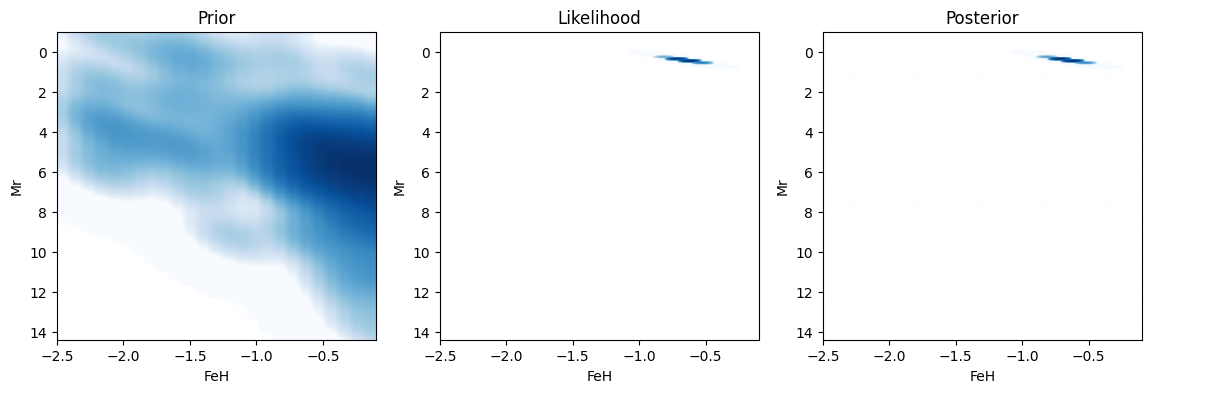

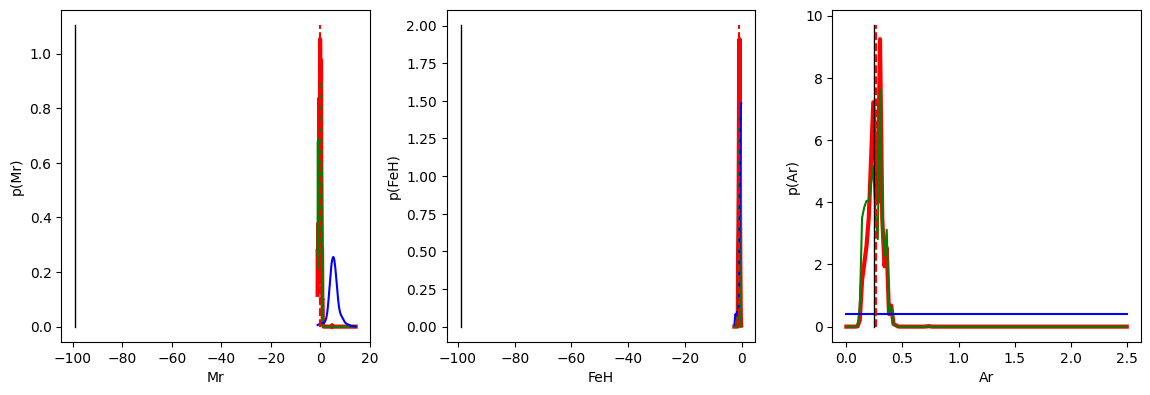

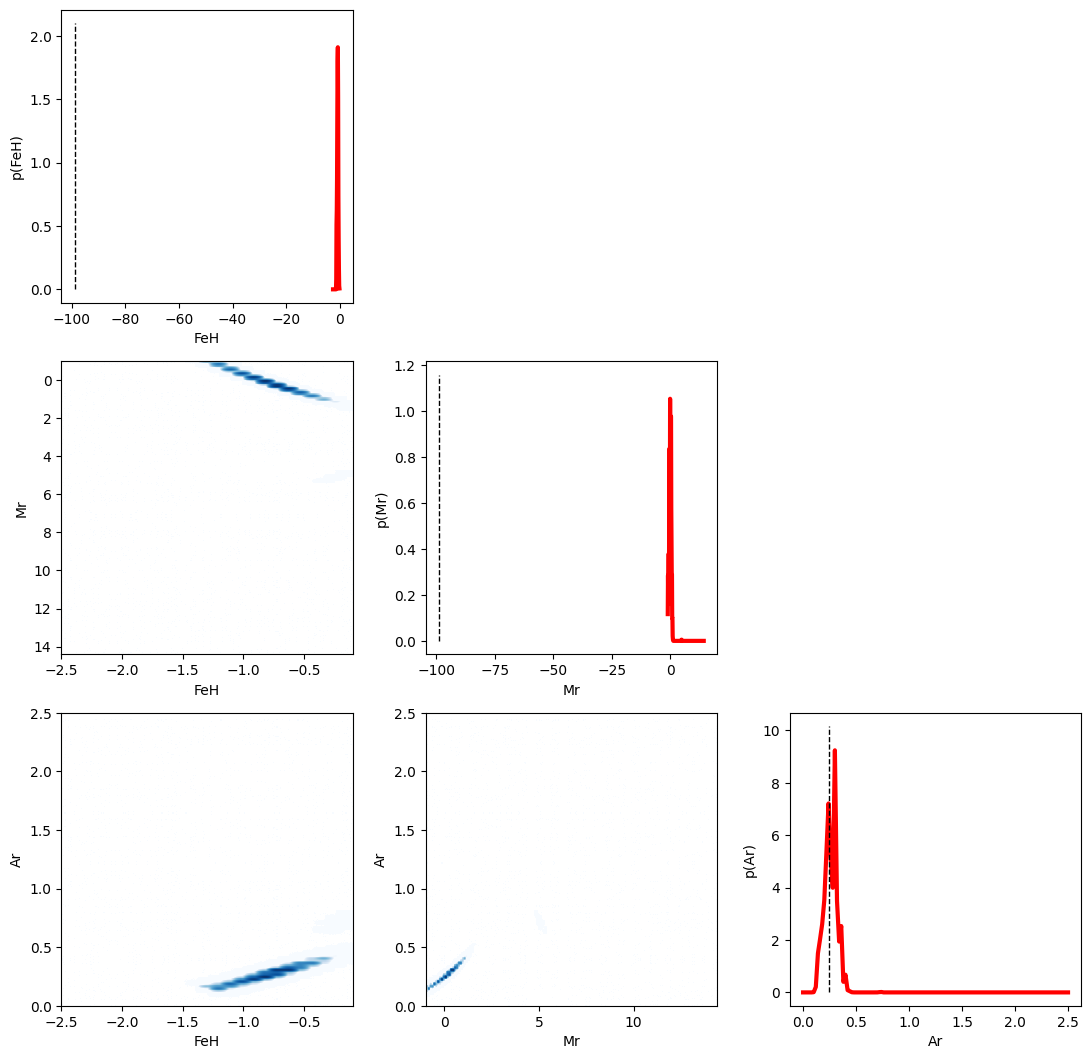

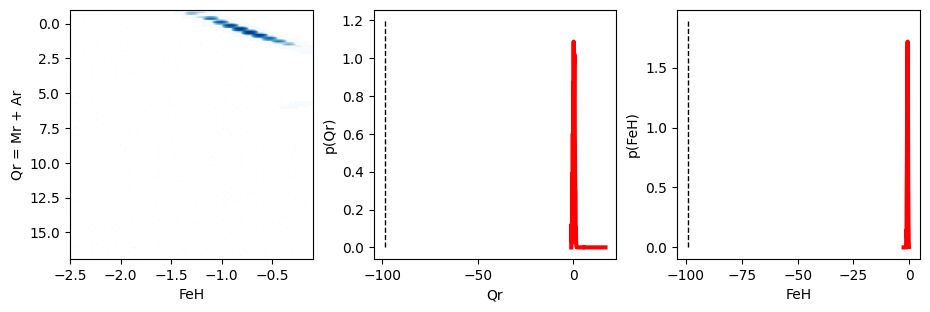

0.40190274 0.4908396


In [15]:
# Plot the results for two of the stars
plotStars = [0,100]
plottingArgs = results.getPlottingArgs() + globalParams.getPlottingArgs()
starResultIndices = [starIndex - iStart for starIndex in plotStars]
bt.plotStars(df.iloc[plotStars], *plottingArgs, starResultIndices)